## План проекта

1 [Подготовка данных](#1)

- 1.1 [Просмотр данных](#1.1)
- 1.2 [Изучение целевого признака](#1.2)
- 1.3 [Добавление признаков](#1.3)
- 1.4 [Обработка выбросов](#1.4)
- 1.5 [Отброс ненужных признаков](#1.5)
- 1.6 [Обработка пропусков](#1.6)
- 1.7 [Обработка дубликатов](#1.7)
Замена типов данных
- 1.8 [Кодирование категориальных признаков](#1.8)
- 1.9 [Выделение целевого признака](#1.9)
- 1.10 [Деление выборки](#1.10)

2 [Обучение моделей](#2)
- 2.1 [Метрика](#2.1)
- 2.2 [Масштабирование признаков](#2.2)
- 2.3 [Обучение базовой модели](#2.3)
- 2.4 [Оптимизация гиперпараметров](#2.4)
- 2.5 [Тестирование моделей](#2.5)
- 2.6 [Проверка моделей на адекватность](#2.6)

3 [Анализ моделей](#3)


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor
from timeit import default_timer as timer

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, 
                             mean_squared_error,
                             make_scorer
                            )
from sklearn.model_selection import (train_test_split,
                                    RandomizedSearchCV, 
                                    GridSearchCV)
sns.set(color_codes=True)


# 1. Подготовка данных<a id="1"></a>

### Просмотр данных<a id="1.1"></a>

In [2]:
def missing_data(data):
    total = data.isnull().sum().sort_values(ascending = False)
    percent = (data.isnull().sum()/data.isnull().count()*100).sort_values(ascending = False)
    return pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

In [3]:
data = pd.read_csv('/datasets/autos.csv')

In [4]:
print('=='*5, 'Info' , '=='*5)
display(data.info())
print('=='*5, 'missing data', '=='*5)
display(missing_data(data))
print('=='*5, 'duplicated', '=='*5)
display(data.duplicated().sum())
print('=='*5, 'describe', '=='*5)
display(data.describe().T)
print('=='*5, 'inspection', '=='*5)
display(data.head(10).T)

========== Info ==========
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


None

========== missing data ==========


,Total,Percent
NotRepaired,71154,20.079070
VehicleType,37490,10.579368
FuelType,32895,9.282697
Gearbox,19833,5.596709
Model,19705,5.560588
LastSeen,0,0.000000
PostalCode,0,0.000000
NumberOfPictures,0,0.000000
DateCreated,0,0.000000
Brand,0,0.000000


========== duplicated ==========


4

========== describe ==========


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


========== inspection ==========


,0,1,2,3,4,5,6,7,8,9
DateCrawled,2016-03-24 11:52:17,2016-03-24 10:58:45,2016-03-14 12:52:21,2016-03-17 16:54:04,2016-03-31 17:25:20,2016-04-04 17:36:23,2016-04-01 20:48:51,2016-03-21 18:54:38,2016-04-04 23:42:13,2016-03-17 10:53:50
Price,480,18300,9800,1500,3600,650,2200,0,14500,999
VehicleType,NaN,coupe,suv,small,small,sedan,convertible,sedan,bus,small
RegistrationYear,1993,2011,2004,2001,2008,1995,2004,1980,2014,1998
Gearbox,manual,manual,auto,manual,manual,manual,manual,manual,manual,manual
Power,0,190,163,75,69,102,109,50,125,101
Model,golf,NaN,grand,golf,fabia,3er,2_reihe,other,c_max,golf
Kilometer,150000,125000,125000,150000,90000,150000,150000,40000,30000,150000
RegistrationMonth,0,5,8,6,7,10,8,7,8,0
FuelType,petrol,gasoline,gasoline,petrol,gasoline,petrol,petrol,petrol,petrol,NaN


### Изучение целевого признака<a id="1.2"></a>

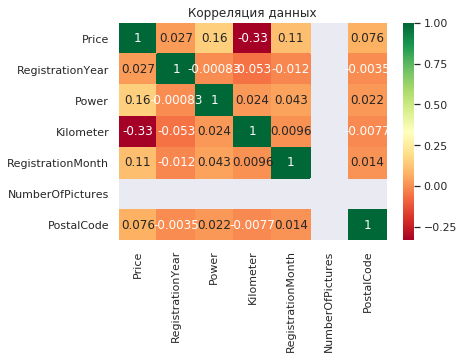

In [5]:
plt.title('Корреляция данных' )
sns.heatmap(data.corr(), cmap='RdYlGn', annot=True)

{'whiskers': [<matplotlib.lines.Line2D at 0x7f4d55a44910>,
 'caps': [<matplotlib.lines.Line2D at 0x7f4d55a37d10>,
 'boxes': [<matplotlib.lines.Line2D at 0x7f4d55a37cd0>],
 'medians': [<matplotlib.lines.Line2D at 0x7f4d55a4edd0>],
 'fliers': [<matplotlib.lines.Line2D at 0x7f4d559d7810>],
 'means': [<matplotlib.lines.Line2D at 0x7f4d55a44ed0>]}

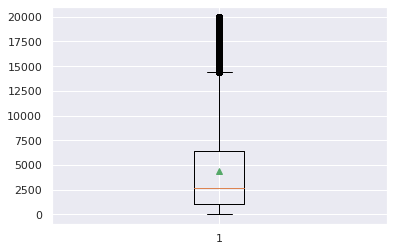

In [6]:
plt.boxplot( data['Price'], showmeans = True)

### Добавление признаков<a id="1.3"></a>

- `'Age_Y'` возраст автомобиля в годах `DateCrawled` - `RegistrationYear` 
- `'LastSeen_D'` - давность активности в днях 

In [7]:
data['Age_Y'] = pd.to_datetime(data.loc[:, 'DateCrawled'], format = '%Y-%m-%d').dt.year - data['RegistrationYear']
data['LastSeen_D'] = (
    pd.to_datetime(data['LastSeen'], format = '%Y-%m-%d')
    - pd.to_datetime(data['DateCreated'], format = '%Y-%m-%d')
).dt.days

### Распределение признаков: Категориальный, численный, для удаления

In [ ]:
# набор быстрый, 5 признаков, rmse ~2100
fitch_drop = ['Brand', 'DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationYear', 'RegistrationMonth', 'VehicleType', 'Gearbox', 'Model', 'FuelType']
numerical = ['Power', 'Kilometer', 'Age_Y', 'LastSeen_D']
categorical = ['NotRepaired']
target_cols = ['Price']

In [8]:
# Нужный набор, 305 признаков, rmse ~1600
fitch_drop = ['DateCrawled', 'DateCreated', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationYear', 'RegistrationMonth']
numerical = ['Power', 'Kilometer', 'Age_Y', 'LastSeen_D']
categorical = ['NotRepaired', 'Brand', 'VehicleType', 'Gearbox', 'Model', 'FuelType']

### Обработка выбросов<a id="1.4"></a>

In [9]:
def drop_ejection(df, columns, lower, upper):
    for column in columns:
        df = df.drop(df[df[column] < lower].index)
        df = df.drop(df[df[column] > upper].index)
    return df

data = drop_ejection(data, ['Power'], 30, 600)
data = drop_ejection(data, ['Age_Y'], 0, 70)
# в мощности моделей есть неверные данные.

### Отброс ненужных признаков<a id="1.5"></a>

In [10]:
data = data.drop(fitch_drop, axis = 1)

### Обработка пропусков<a id="1.6"></a>

In [11]:
#data['NotRepaired'] = data['NotRepaired'].fillna('unknown')
#data['FuelType'] = data['FuelType'].fillna('unknown')

print('отброшено пропусков {:.2%}'.format((data.isna().sum().sum())/data.shape[0]))
data = data.dropna()


отброшено пропусков 30.14%


### Обработка дубликатов<a id="1.7"></a>

In [12]:
print('отброшено дубликатов {:.2%}'.format((data.duplicated().sum().sum())/data.shape[0]))
data = data.drop_duplicates().reset_index(drop = True)

отброшено дубликатов 4.67%


### Замена типов данных

In [13]:
data[categorical] = data[categorical].astype("category")

## Выборка для CatBoost, Light GBM
Без кодирования признаков

In [14]:
features = data.drop(['Price'], axis=1)
target = data['Price']

fb_train, fb_test, tb_train, tb_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)
fb_valid, fb_test, tb_valid, tb_test = train_test_split(
    fb_test, tb_test, test_size=0.5, random_state=12345)

print('boost_train', fb_train.shape , tb_train.shape)
print('boost_valid', fb_valid.shape, tb_valid.shape)
print('boost_test', fb_test.shape, tb_test.shape)


boost_train (134773, 10) (134773,)
boost_valid (44925, 10) (44925,)
boost_test (44925, 10) (44925,)


## Выборка для LinearRegression, DecisionTreeRegressor, RandomForestRegressor

### Кодирование категориальных признаков<a id="1.8"></a>

In [15]:
# OneHotEncoder
data = pd.get_dummies(data, columns=categorical, drop_first=True)

### Выделение целевого признака<a id="1.9"></a>

In [16]:
features = data.drop(['Price'], axis=1)
target = data['Price']
display(fe  

(224623, 305)

(224623,)

### Деление выборки<a id="1.10"></a>

In [17]:
features_train, features_test, target_train, target_test = train_test_split(
    features, target, test_size=0.4, random_state=12345)
features_valid, features_test, target_valid, target_test = train_test_split(
    features_test, target_test, test_size=0.5, random_state=12345)

print('features_train', features_train.shape)
print('target_train', target_train.shape)
print('features_valid', features_valid.shape)
print('target_valid', target_valid.shape)
print('features_test', features_test.shape)
print('target_test', target_test.shape)

features_train (134773, 305)
target_train (134773,)
features_valid (44925, 305)
target_valid (44925,)
features_test (44925, 305)
target_test (44925,)


### Масштабирование признаков<a id="2.2"></a>

In [18]:
sc = StandardScaler()
features_train = sc.fit_transform(features_train)
features_valid = sc.transform(features_valid)
features_test = sc.transform(features_test)

# 2. Обучение моделей<a id="2"></a>

### Метрика<a id="2.1"></a>

In [19]:
time_fit = []

def RootMSE(target, predict): 
    return mean_squared_error(target, predict)**0.5

def predict_test_RMSE(model, f_test, t_test):
    t = timer()
    return round(RootMSE(t_test, model.predict(f_test)), 2), round(timer() - t, 2)

scorer = make_scorer(RootMSE)

### Обучение базовой модели<a id="2.3"></a>

In [20]:
base_forest_model = RandomForestRegressor(random_state=12345)
t = timer()
base_forest_model.fit(features_train, target_train)
time_train = timer() - t

rmse, time_predict = predict_test_RMSE(base_forest_model, features_test, target_test)
print('RMSE test', rmse)
time_fit.append(['Base_forest', rmse, time_train, time_predict])

/opt/conda/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RMSE test 1729.89


### Тестирование моделей<a id="2.5"></a>

### LinearRegression

In [21]:
#3158.78, 2746.07, 2531.85, переобучается
lr_model = LinearRegression()
t = timer()
lr_model.fit(features_train, target_train)
time_train = timer() - t

rmse, time_predict = predict_test_RMSE(lr_model, features_test, target_test)
print('RMSE test', rmse)
time_fit.append(['LinearRegression', rmse, time_train, time_predict])

RMSE test 2510.9


### DecisionTreeRegressor

In [22]:
# 2680.12, 2294.01, 2155.30
tree_model = DecisionTreeRegressor(random_state=12345)
t = timer()
tree_model.fit(features_train, target_train)
time_train = timer() - t

rmse, time_predict = predict_test_RMSE(tree_model, features_test, target_test)
print('RMSE test', rmse)
time_fit.append(['DecisionTreeRegressor', rmse, time_train, time_predict])

RMSE test 2162.34


### RandomForestRegressor. 
### Оптимизация гиперпараметров с GridSearchCV<a id="2.4"></a>

In [23]:
%%time
param_grid = {'n_estimators': [70],
               'max_depth': [22],
}
gs = GridSearchCV(
    base_forest_model, 
    param_grid, 
    cv = 2, 
    verbose = 1, 
    n_jobs=-1, 
    scoring = scorer
)
gs.fit(features_train, target_train)
gs.best_params_

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:  4.6min finished


CPU times: user 7min 56s, sys: 958 ms, total: 7min 57s
Wall time: 8min 4s


{'max_depth': 22, 'n_estimators': 70}

In [24]:
#2226.75, 1756, 1652.73
forest_model = RandomForestRegressor(
     n_estimators = 70,
     max_depth= 22,
     random_state=12345)                                   
t = timer()
forest_model.fit(features_train, target_train)
time_train = timer() - t

rmse, time_predict = predict_test_RMSE(forest_model, features_test, target_test)
print('RMSE test', rmse)
time_fit.append(['RandomForestRegressor', rmse, time_train, time_predict])


RMSE test 1658.0


## Light GBM

### GridSearchCV

In [25]:
%%time
lg = lgb.LGBMRegressor(silent=False)

params_gs = {
    'boosting_type': ['gbdt'],
    'metric': ['rmse'],
    'objective': ['regression'],
    'num_leaves': [int(x) for x in np.linspace(start = 900, stop = 1000, num = 1)], # (max_depth)^2
    'learning_rate': [0.25], #0.001 .... 0.25
    'feature_fraction': [0.9], 
    'bagging_fraction': [0.9],
    'bagging_freq': [5],
    'verbose': [0],
    "n_estimators": [int(x) for x in np.linspace(start = 20, stop = 80, num = 2)],
    'max_depth': [int(x) for x in np.linspace(start = 30, stop = 50, num = 1)]
    }

gs_lgb = GridSearchCV(lg, 
                  n_jobs = -1, 
                  param_grid = params_gs, 
                  cv = 2, # 1...5
                  scoring = scorer, 
                  verbose = 2
                 )

gs_lgb.fit(fb_train,tb_train)
gs_lgb.best_score_
gs_lgb.best_params_

Fitting 2 folds for each of 2 candidates, totalling 4 fits
[CV] bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=20, num_leaves=900, objective=regression, verbose=0 


[Parallel(n_jobs=-1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=20, num_leaves=900, objective=regression, verbose=0, total= 4.8min
[CV] bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=20, num_leaves=900, objective=regression, verbose=0 


[Parallel(n_jobs=-1)]: Done   1 out of   1 | elapsed:  4.8min remaining:    0.0s


[CV]  bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=20, num_leaves=900, objective=regression, verbose=0, total=  53.5s
[CV] bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=80, num_leaves=900, objective=regression, verbose=0 
[CV]  bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=80, num_leaves=900, objective=regression, verbose=0, total= 3.3min
[CV] bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=80, num_leaves=900, objective=regression, verbose=0 
[CV]  bagging_fraction=0.9, bagging_freq=5, boosting_type=gbdt, feature_fraction=0.9, learning_rate=0.25, max_depth=30, metric=rmse, n_estimators=80, num_leaves=900, objective=re

[Parallel(n_jobs=-1)]: Done   4 out of   4 | elapsed: 12.5min finished


CPU times: user 16min 14s, sys: 6.62 s, total: 16min 21s
Wall time: 16min 27s


{'bagging_fraction': 0.9,
 'bagging_freq': 5,
 'boosting_type': 'gbdt',
 'feature_fraction': 0.9,
 'learning_rate': 0.25,
 'max_depth': 30,
 'metric': 'rmse',
 'n_estimators': 80,
 'num_leaves': 900,
 'objective': 'regression',
 'verbose': 0}

In [26]:
lgb_train = lgb.Dataset(fb_train, tb_train)
lgb_valid = lgb.Dataset(fb_valid, tb_valid, reference=lgb_train)

params = gs_lgb.best_params_
t = timer()
gbm = lgb.train(params,
                lgb_train,
                #num_boost_round=20,
                categorical_feature = categorical,
                valid_sets=lgb_valid,
                early_stopping_rounds=3
                )
time_train = timer() - t

rmse, time_predict = predict_test_RMSE(gbm, fb_test, tb_test)
print('RMSE test', rmse)
time_fit.append(['LightGBM', rmse, time_train, time_predict])


/opt/conda/lib/python3.7/site-packages/lightgbm/engine.py:148: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.7/site-packages/lightgbm/basic.py:1295: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['Brand', 'FuelType', 'Gearbox', 'Model', 'NotRepaired', 'VehicleType']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's rmse: 3742.15
Training until validation scores don't improve for 3 rounds
[2]	valid_0's rmse: 3047.86
[3]	valid_0's rmse: 2556.17
[4]	valid_0's rmse: 2226.75
[5]	valid_0's rmse: 1997.73
[6]	valid_0's rmse: 1858.53
[7]	valid_0's rmse: 1759.69
[8]	valid_0's rmse: 1697.58
[9]	valid_0's rmse: 1659.46
[10]	valid_0's rmse: 1632.04
[11]	valid_0's rmse: 1613.51
[12]	valid_0's rmse: 1601.57
[13]	valid_0's rmse: 1593.72
[14]	valid_0's rmse: 1588.63
[15]	valid_0's rmse: 1583.17
[16]	valid_0's rmse: 1581.16
[17]	valid_0's rmse: 1577.72
[18]	valid_0's rmse: 1577.74
[19]	valid_0's rmse: 1576.42
[20]	valid_0's rmse: 1576.49
[21]	valid_0's rmse: 1576.19
[22]	valid_0's rmse: 1576.03
[23]	valid_0's rmse: 1576.29
[24]	valid_0's rmse: 1577
[25]	valid_0's rmse: 1577.4
Early stopping, best iteration is:
[22]	valid_0's rmse: 1576.03
RMSE test 1577.15


## CatBoost

In [27]:
def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

cat_features_index = column_index(fb_train, categorical)
# num_features_index = column_index(features, numerical)

In [28]:
def dict_to_str(dictionary):
    strings = []
    for key,item in dictionary.items():
        strings.append("{} = {}".format(key, item))
    result = ", ".join(strings)
    print(result)


In [29]:
%%time
params = {'depth': [7],
          'learning_rate' : [0.05, 0.1],
         'l2_leaf_reg': [3,9],
         'iterations': [300]}

catb = CatBoostRegressor()
gs_catbl = GridSearchCV(catb, 
                        params, 
                        scoring = scorer,
                        verbose = 2,
                        cv = 2)

gs_catbl.fit(fb_train, tb_train, cat_features=cat_features_index, logging_level='Silent')
print(gs_catbl.best_score_)
print(gs_catbl.best_params_)
#{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 9, 'learning_rate': 0.05}
# gs_catbl: model

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.05 ......


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV]  depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.05, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.05 ......


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.4min remaining:    0.0s


[CV]  depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.05, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.1, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=3, learning_rate=0.1, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.05 ......
[CV]  depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.05, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.05 ......
[CV]  depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.05, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.1, total= 1.4min
[CV] depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.1 .......
[CV]  depth=7, iterations=300, l2_leaf_reg=9, learning_rate=0.1, total= 1.4min


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 11.2min finished


1700.3543167380335
{'depth': 7, 'iterations': 300, 'l2_leaf_reg': 9, 'learning_rate': 0.05}


In [30]:
catb = CatBoostRegressor(dict_to_str(gs_catbl.best_params_))

catb.fit(fb_train,
         tb_train,
         cat_features=cat_features_index,
         eval_set=(fb_valid, tb_valid),
         logging_level='Silent'
        )

rmse, time_predict = predict_test_RMSE(catb, fb_test, tb_test)
print('RMSE test', rmse)
time_fit.append(['CatBoost', rmse, time_train, time_predict])

depth = 7, iterations = 300, l2_leaf_reg = 9, learning_rate = 0.05
RMSE test 1626.45


## Проверка моделей на адекватность<a id="2.6"></a>

In [31]:
t = timer()
predict_mean = pd.Series(target_train.mean(), index=target_train.index)
time_predict = timer() - t
rmse = RootMSE(target_train, predict_mean)
print('RMSE', rmse)
time_fit.append(['LinearRegression', rmse, 0.0, time_predict])

RMSE 4747.448554626195


# 3. Анализ моделей<a id="3"></a>

In [32]:
def total_print(df):
    x = df['Model'] 
    y1 = df['RMSE']
    y2 = df['time_train']
    y3 = df['time_predict']

    fig, axes = plt.subplots(3,1,figsize=(14,10), dpi= 80)
    axes[0].bar( x, y1,color='tab:red', width = 0.5)
    axes[1].bar(x, y2, color='tab:blue', width = 0.5)
    axes[2].bar(x, y3, color='tab:green', width = 0.5)

    axes[0].set_title('Результаты обучения моделей', fontsize=20)
    axes[0].set_ylabel('RMSE', color='tab:red', fontsize=16)
    axes[0].tick_params(axis='y', rotation=0, labelcolor='tab:red' )

    axes[1].set_ylabel('Training time, sec', color='tab:blue', fontsize=16)
    axes[1].tick_params(axis='y', labelcolor='tab:blue')

    axes[2].set_ylabel('Predict time, sec', color='tab:green', fontsize=16)
    axes[2].tick_params(axis='y', labelcolor='tab:green')

    axes[2].set_xlabel('Models', fontsize=16)
    axes[2].tick_params(axis='x', rotation=0, labelsize=12)
    axes[0].set_xticks([])

    plt.show()

In [33]:
score_time = pd.DataFrame(time_fit, columns = ['Model', 'RMSE', 'time_train', 'time_predict'])

In [34]:
display(score_time)

,Model,RMSE,time_train,time_predict
0,Base_forest,1729.890000,36.628780,0.350000
1,LinearRegression,2510.900000,19.381660,0.100000
2,DecisionTreeRegressor,2162.340000,6.103011,0.090000
3,RandomForestRegressor,1658.000000,221.916561,1.420000
4,LightGBM,1577.150000,74.175267,0.400000
5,CatBoost,1626.450000,74.175267,0.330000
6,LinearRegression,4747.448555,0.000000,0.001695


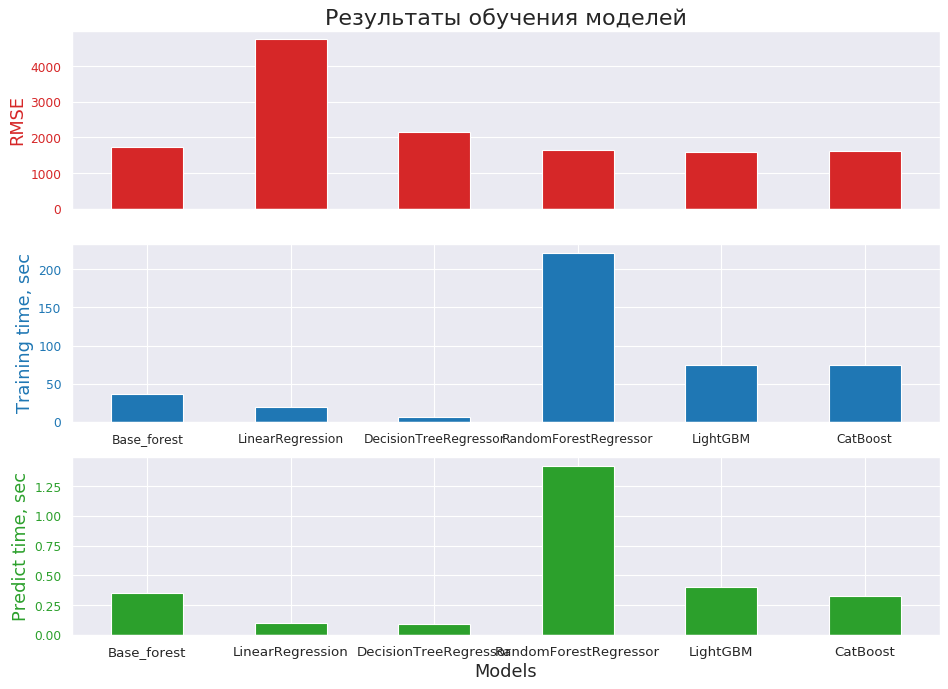

In [35]:
total_print(score_time)